In [1]:
import os
import shutil

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
import numpy as np

2023-11-26 21:43:25.212660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_and_preprocess_image(path, target_size=(256, 256)):
    img = tf.keras.preprocessing.image.load_img(path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.cast(img_array, tf.float32) / 255.0  # Normalize to [0,1]
    return img_array

def load_images_from_folder(folder, target_size=(256, 256)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img_array = load_and_preprocess_image(img_path, target_size)
        images.append(img_array)
    return np.array(images)

# Load and preprocess images and masks into separate arrays
train_images = load_images_from_folder('train-images')
test_images = load_images_from_folder('test-images')

In [3]:
def load_and_preprocess_mask(path, target_size=(256, 256)):
    mask = tf.keras.preprocessing.image.load_img(path, target_size=target_size, color_mode='grayscale')
    mask_array = tf.keras.preprocessing.image.img_to_array(mask)
    mask_array = tf.cast(mask_array, tf.float32) / 255.0  # Normalize to [0,1]
    return mask_array

def load_masks_from_folder(folder, target_size=(256, 256)):
    masks = []
    for filename in os.listdir(folder):
        mask_path = os.path.join(folder, filename)
        mask_array = load_and_preprocess_mask(mask_path, target_size)
        masks.append(mask_array)
    return np.array(masks)

# Load and preprocess masks
train_masks = load_masks_from_folder('train-masks')
test_masks = load_masks_from_folder('test-masks')

In [4]:
def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        return lr * 0.1
    else:
        return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)



In [5]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [6]:
model_adam = Sequential([
    # Encoder
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    # Decoder
    Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same'),
    Conv2D(1, (1, 1), activation='relu')
])

model_adam.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
from tensorflow.keras.metrics import MeanIoU

def pixel_accuracy(y_true, y_pred):
    correct_predictions = tf.equal(tf.round(y_pred), tf.round(y_true))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

model_adam.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', pixel_accuracy])

In [8]:
history_adam = model_adam.fit(
    train_images, 
    train_masks, 
    batch_size=32, 
    epochs=10, 
    validation_data=(test_images, test_masks),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/10
15/15 [==============================] - 65s 4s/step - loss: 0.3901 - accuracy: 0.8973 - pixel_accuracy: 0.8969 - val_loss: 0.3149 - val_accuracy: 0.9068 - val_pixel_accuracy: 0.9072 - lr: 0.0010
Epoch 2/10
15/15 [==============================] - 63s 4s/step - loss: 0.3240 - accuracy: 0.8995 - pixel_accuracy: 0.8996 - val_loss: 0.3102 - val_accuracy: 0.9068 - val_pixel_accuracy: 0.9072 - lr: 0.0010
Epoch 3/10
15/15 [==============================] - 67s 4s/step - loss: 0.3209 - accuracy: 0.8995 - pixel_accuracy: 0.8992 - val_loss: 0.3075 - val_accuracy: 0.9068 - val_pixel_accuracy: 0.9072 - lr: 0.0010
Epoch 4/10
15/15 [==============================] - 63s 4s/step - loss: 0.3193 - accuracy: 0.8995 - pixel_accuracy: 0.8996 - val_loss: 0.3065 - val_accuracy: 0.9068 - val_pixel_accuracy: 0.9072 - lr: 0.0010
Epoch 5/10
15/15 [==============================] - 73s 5s/step - loss: 0.3163 - accuracy: 0.8995 - pixel_accuracy: 0.8996 - val_loss: 0.3074 - val_accuracy: 0.9068 - val_p

In [12]:
import matplotlib.pyplot as plt


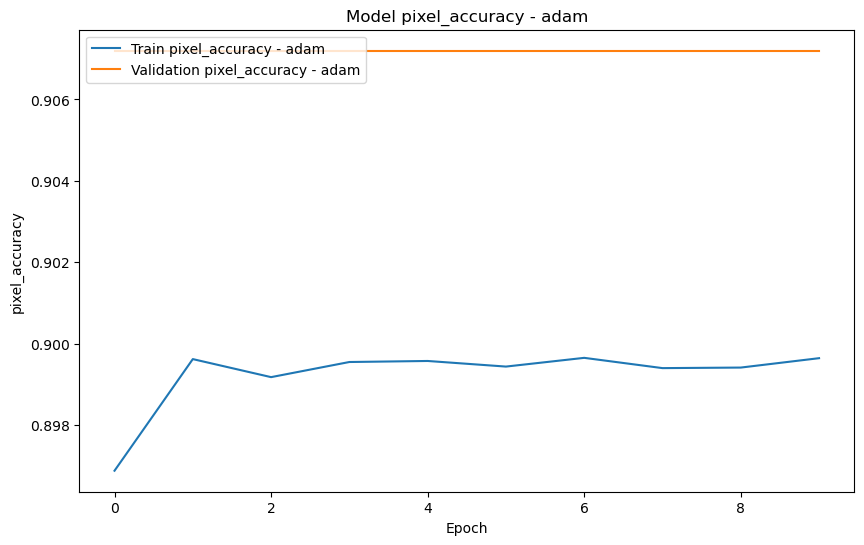

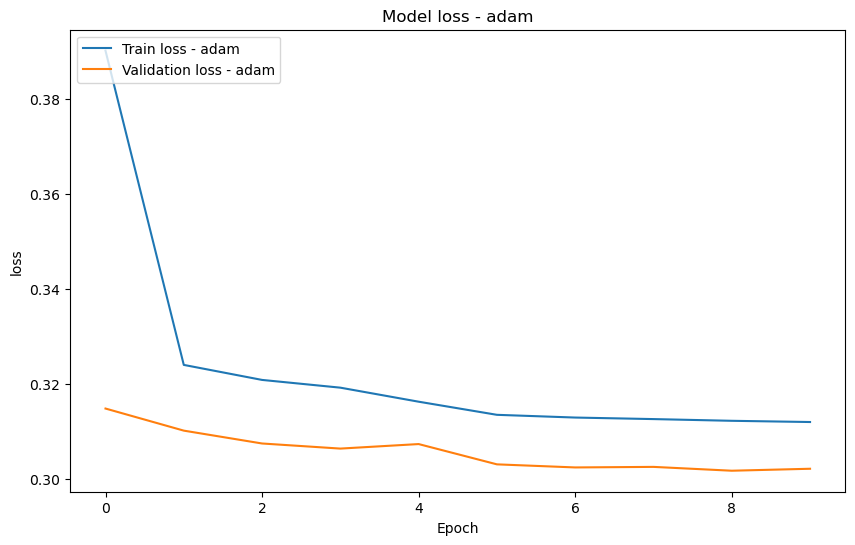

In [24]:
plt.figure(figsize=(10, 6))
plot_model_performance(history_adam, 'adam', 'pixel_accuracy')
plt.show()

plt.figure(figsize=(10, 6))
plot_model_performance(history_adam, 'adam', 'loss')
plt.show()

In [14]:
model_SGD = Sequential([
    # Encoder
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    # Decoder
    Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same'),
    Conv2D(1, (1, 1), activation='relu')
])

model_SGD.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
from tensorflow.keras.metrics import MeanIoU

def pixel_accuracy(y_true, y_pred):
    correct_predictions = tf.equal(tf.round(y_pred), tf.round(y_true))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

model_SGD.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', pixel_accuracy])

In [16]:
history_SGD = model_SGD.fit(
    train_images, 
    train_masks, 
    batch_size=32, 
    epochs=10, 
    validation_data=(test_images, test_masks),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/10
15/15 [==============================] - 59s 4s/step - loss: 0.3951 - accuracy: 0.8920 - pixel_accuracy: 0.8923 - val_loss: 0.3146 - val_accuracy: 0.9068 - val_pixel_accuracy: 0.9072 - lr: 0.0010
Epoch 2/10
15/15 [==============================] - 63s 4s/step - loss: 0.3234 - accuracy: 0.8995 - pixel_accuracy: 0.8997 - val_loss: 0.3100 - val_accuracy: 0.9068 - val_pixel_accuracy: 0.9072 - lr: 0.0010
Epoch 3/10
15/15 [==============================] - 63s 4s/step - loss: 0.3201 - accuracy: 0.8995 - pixel_accuracy: 0.8995 - val_loss: 0.3081 - val_accuracy: 0.9068 - val_pixel_accuracy: 0.9072 - lr: 0.0010
Epoch 4/10
15/15 [==============================] - 76s 5s/step - loss: 0.3188 - accuracy: 0.8995 - pixel_accuracy: 0.8997 - val_loss: 0.3069 - val_accuracy: 0.9068 - val_pixel_accuracy: 0.9072 - lr: 0.0010
Epoch 5/10
15/15 [==============================] - 63s 4s/step - loss: 0.3176 - accuracy: 0.8995 - pixel_accuracy: 0.8998 - val_loss: 0.3050 - val_accuracy: 0.9068 - val_p

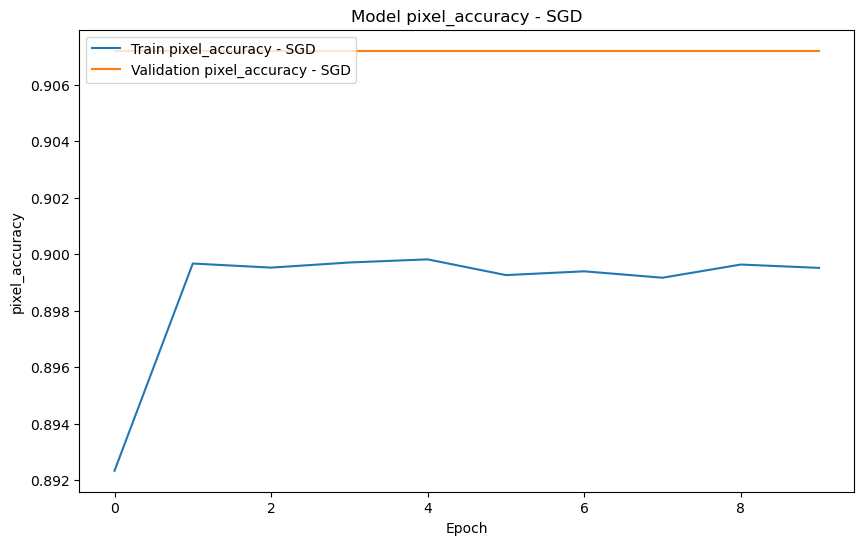

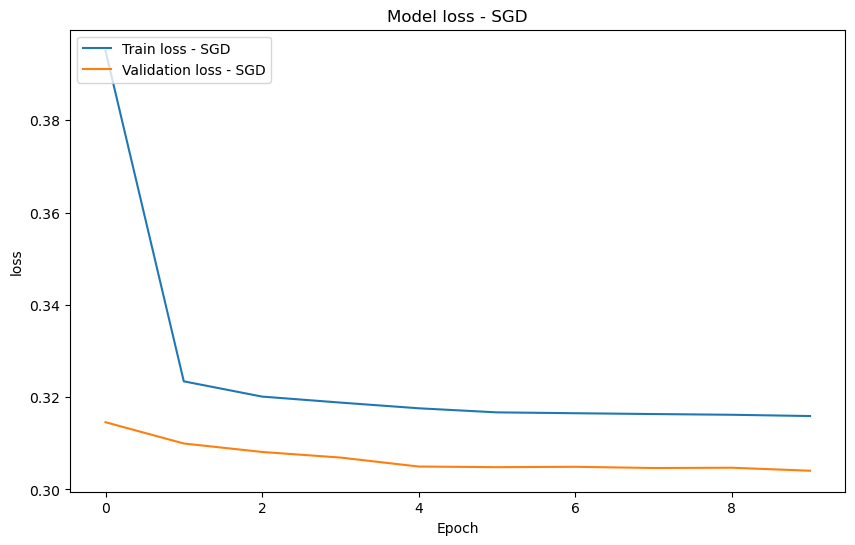

In [23]:
plt.figure(figsize=(10, 6))
plot_model_performance(history_SGD, 'SGD', 'pixel_accuracy')
plt.show()

plt.figure(figsize=(10, 6))
plot_model_performance(history_SGD, 'SGD', 'loss')
plt.show()

In [17]:
model_adagrad = Sequential([
    # Encoder
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    # Decoder
    Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same'),
    Conv2D(1, (1, 1), activation='relu')
])

model_adagrad.compile(optimizer='adagrad', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
from tensorflow.keras.metrics import MeanIoU

def pixel_accuracy(y_true, y_pred):
    correct_predictions = tf.equal(tf.round(y_pred), tf.round(y_true))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

model_adagrad.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', pixel_accuracy])

In [19]:
history_adagrad = model_adagrad.fit(
    train_images, 
    train_masks, 
    batch_size=32, 
    epochs=10, 
    validation_data=(test_images, test_masks),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/10
15/15 [==============================] - 70s 4s/step - loss: 0.4168 - accuracy: 0.8984 - pixel_accuracy: 0.8985 - val_loss: 0.3153 - val_accuracy: 0.9068 - val_pixel_accuracy: 0.9072 - lr: 0.0010
Epoch 2/10
15/15 [==============================] - 63s 4s/step - loss: 0.3258 - accuracy: 0.8995 - pixel_accuracy: 0.8994 - val_loss: 0.3094 - val_accuracy: 0.9068 - val_pixel_accuracy: 0.9072 - lr: 0.0010
Epoch 3/10
15/15 [==============================] - 63s 4s/step - loss: 0.3221 - accuracy: 0.8995 - pixel_accuracy: 0.8997 - val_loss: 0.3089 - val_accuracy: 0.9068 - val_pixel_accuracy: 0.9072 - lr: 0.0010
Epoch 4/10
15/15 [==============================] - 62s 4s/step - loss: 0.3210 - accuracy: 0.8995 - pixel_accuracy: 0.8995 - val_loss: 0.3079 - val_accuracy: 0.9068 - val_pixel_accuracy: 0.9072 - lr: 0.0010
Epoch 5/10
15/15 [==============================] - 62s 4s/step - loss: 0.3192 - accuracy: 0.8995 - pixel_accuracy: 0.8993 - val_loss: 0.3078 - val_accuracy: 0.9068 - val_p

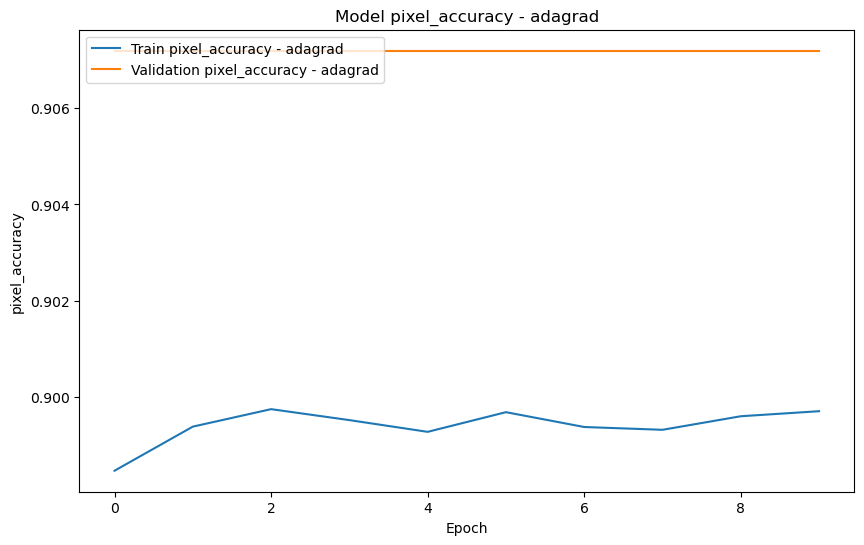

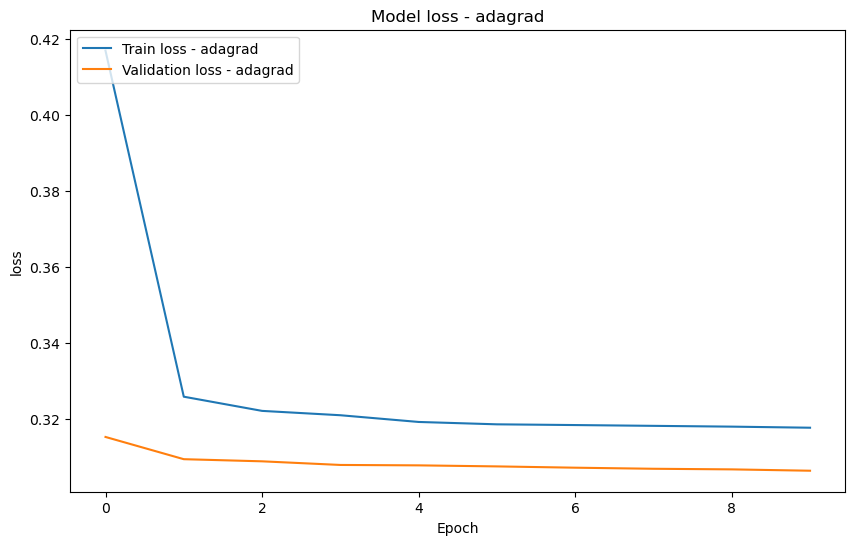

In [22]:
plt.figure(figsize=(10, 6))
plot_model_performance(history_adagrad, 'adagrad', 'pixel_accuracy')
plt.show()

plt.figure(figsize=(10, 6))
plot_model_performance(history_adagrad, 'adagrad', 'loss')
plt.show()